In [1]:
using TaylorIntegration, ValidatedNumerics, TaylorSeries
using Plots, LaTeXStrings
# plotly()
pyplot(grid = :false, legend = :false)
const λ = 1.0
const Z = 2.0
const order = 30
const t0 = 0.0
const t_max = 0.5 
const abs_tol = 1.0E-20
const steps = 500000

500000

In [2]:
f(x, y) = [x^2 - y^2, 2x*y]
f(v) = f(v...)

f (generic function with 2 methods)

In [3]:
function undrivenHelium{T<:Real}(τ::T, q::Array{T,1})
    t, Q1x, Q1y, Q2x, Q2y, P1x, P1y, P2x, P2y = q
    
    #Cantidades auxiliares
    Q₁² = Q1x^2 + Q1y^2
    Q₂² = Q2x^2 + Q2y^2
    P₁² = P1x^2 + P1y^2
    P₂² = P2x^2 + P2y^2
    t = Q₁²*Q₂²
    rf = f(Q1x, Q1y) - f(Q2x, Q2y)
    f₁, f₂ = rf
    fs = f₁^2 + f₂^2
    nf = (fs)^(1/2)
    nf³ = (fs)^(3/2)
    factor1 = 2t/nf³
    
    q1x, q1y = 0.25*Q₂²*[P1x, P1y]
    q2x, q2y = 0.25*Q₁²*[P2x, P2y]
    p1x, p1y = 2*(-0.125P₂² + Z - Q₂²*(1 + 1/nf))*[Q1x, Q1y]
    + factor1*(f₁*[Q1x, -Q1y] + f₂*[Q1y, Q1x])
    
    p2x, p2y = 2*(-0.125P₁² + Z - Q₁²*(1 + 1/nf))*[Q2x, Q2y]
    - factor1*(f₁*[Q2x, -Q2y] + f₂*[Q2y, Q2x]) 
   
    return T[t, q1x, q1y, q2x, q2y, p1x, p1y, p2x, p2y]
end
undrivenHelium(v) = undrivenHelium(zero(eltype(v)), v)


var1 = set_variables("t q1x q1y q2x q2y p1x p1y p2x p2y", order = 1)


#function condini(x10::Float64, px10::Float64)
#    @assert x10 != 0
#    Q1 = sqrt(x10)
#    Q2 = 0.0
#    P1 = px10*sqrt(x10)    
#    P2 = sqrt(nf³8Z)    
#    return [0, Q1, Q2, P1, P2]
#end

function regHam{T<:Any}(t::T, q1x::T, q1y::T, q2x::T, q2y::T, p1x::T, p1y::T, p2x::T, p2y::T)
    #Cantidades auxiliares
    Q₁² = q1x^2 + q1y^2
    Q₂² = q2x^2 + q2y^2
    P₁² = p1x^2 + p1y^2
    P₂² = p2x^2 + p2y^2
    t = Q₁²*Q₂²
    rf = f(q1x, q1y) - f(q2x, q2y)
    f₁, f₂ = rf
    nf = (f₁^2 + f₂^2)^(1/2)
    
    H = 0.125*(P₁²*Q₂² + P₂²*Q₁²) - Z*(Q₁² + Q₂²) + t*(1.0 + 1.0/nf)
    return H
end


regHam(v) = regHam(v...)

regHam (generic function with 2 methods)

In [4]:
function errHam(N::Int)
    srand(487293456)
    J = [0 0 0 0 0 0 0 0 0; 0 0 0 0 0 1 0 0 0; 0 0 0 0 0 0 1 0 0; 
    0 0 0 0 0 0 0 1 0; 0 0 0 0 0 0 0 0 1; 0 -1 0 0 0 0 0 0 0; 
    0 0 -1 0 0 0 0 0 0; 0 0 0 -1 0 0 0 0 0; 0 0 0 0 -1 0 0 0 0]
    
    dnorm = zeros(N)
    
    for j in 1:N
        al = 10*rand(9)
        alt = al + var1
        ene = J*∇(regHam(alt))
        ene1 = Float64[ene[k].coeffs[1].coeffs[1] for k in 1:9]
        meq = undrivenHelium(al)
        meq[1] = 0
        dnorm[j] = norm(meq - ene1) 
    end
    return dnorm  
end


errHam (generic function with 1 method)

  0.859675 seconds (1.80 M allocations: 89.453 MB, 3.14% gc time)



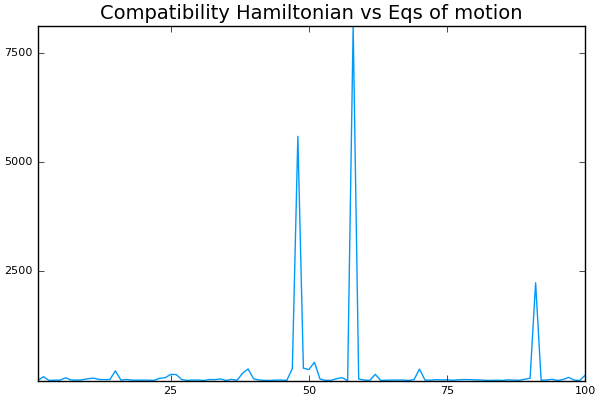

In [5]:
@time dnorm = errHam(100);
plot(eachindex(dnorm), dnorm, title = "Compatibility Hamiltonian vs Eqs of motion")


In [6]:
maximum(dnorm), minimum(dnorm)

(8118.1056419370625,0.020022097327834103)

In [ ]:
#Haremos malavares con metaprogramming para ver varias órbitas
nombret(n::Int) = Symbol( string("t", n) )
nombreq(n::Int) = Symbol( string("q", n) )

function orbits(rs = 2:10)
    N = length(rs)
    # Checo que `n` sea >= 1
    @assert N >= 0  

    for j = 1:N
        ex = quote 
                $(nombret(j)), $(nombreq(j)) = 
                taylorinteg(undrivenHelium, condini(Float64($(rs[j])), 0.0), t0, 
                15.0, order, abs_tol, maxsteps=steps) 
             end
        eval(ex)  
    end
end

The final state:

In [ ]:
orbits()

In [ ]:
t1[end], q1[end,:]

In [ ]:
regHam(q1[end,:])

In [ ]:
ene = zeros(t1)
for j in eachindex(ene)
    ene[j] = abs(regHam(q1[j,:]))
end

In [ ]:
plot(q1[:,1], ene, title =L"Absolute Error of Energy $q_1=2$")
xlabel!(L"t")
ylabel!(L"\delta E")

In [ ]:
function ksv(Q, P)
    v₁ = P/Q
    return v₁
end
ks(Q) = Q^2

In [ ]:
xs1 = map(ks, q1[:,2])
vxs1 = Float64[ksv(q1[j,2], q1[j, 4]) for j in eachindex(t1)]
xs2 = map(ks, q2[:,2])
vxs2 = Float64[ksv(q2[j,2], q2[j, 4]) for j in eachindex(t2)]
xs3 = map(ks, q3[:,2])
vxs3 = Float64[ksv(q3[j,2], q3[j, 4]) for j in eachindex(t3)]
xs4 = map(ks, q4[:,2])
vxs4 = Float64[ksv(q4[j,2], q4[j, 4]) for j in eachindex(t4)]
xs5 = map(ks, q5[:,2])
vxs5 = Float64[ksv(q5[j,2], q5[j, 4]) for j in eachindex(t5)]
xs6 = map(ks, q6[:,2])
vxs6 = Float64[ksv(q6[j,2], q6[j, 4]) for j in eachindex(t6)]
xs7 = map(ks, q7[:,2])
vxs7 = Float64[ksv(q7[j,2], q7[j, 4]) for j in eachindex(t7)]
xs8 = map(ks, q8[:,2])
vxs8 = Float64[ksv(q8[j,2], q8[j, 4]) for j in eachindex(t8)]
xs9 = map(ks, q9[:,2])
vxs9 = Float64[ksv(q9[j,2], q9[j, 4]) for j in eachindex(t9)];

In [ ]:
plot(xs1, vxs1, label = L"q = 2", title = L"Poincaré Section $Z = 2$,  $r_{2_0} =0$", legend =:true)
plot!(xs2, vxs2, label = L"q = 3")
plot!(xs3, vxs3, label = L"q = 4")
plot!(xs4, vxs4, label = L"q = 5")
plot!(xs5, vxs5, label = L"q = 6")
plot!(xs6, vxs6, label = L"q = 7")
plot!(xs7, vxs7, label = L"q = 8")
plot!(xs8, vxs8, label = L"q = 9")
plot!(xs9, vxs9, label = L"q = 10")
xaxis!([0,20])
xlabel!(L"x")
ylabel!(L"p_x")
yaxis!([-1,1])

In [ ]:
function HamU(t, Q₁, P₁, Q₂, P₂)
    #Cantidades auxiliares
    P₁² = P₁^2
    P₂² = P₂^2
    Q₁² = Q₁^2
    Q₂² = Q₂^2
    nq = abs(Q₁ - Q₂)
    
    H = 0.5*(P₁² + P₂²) - Z*(1/abs(Q₁)+1/abs(Q₂)) + 1.0/nq
    return H
end
HamU(v) = HamU(v...)

In [ ]:
ene1 = zeros(t1)
for j in 2:length(t1)
    ene1[j] = abs(HamU(q1[j,:]) + 1)
end

In [ ]:
plot(q1[:,1], ene1, title ="Error de energía, espacio de configuración original")
xlabel!(L"t")
ylabel!(L"\delta E")